# 基于LSTM分词

In [1]:
from keras.layers import Embedding,SimpleRNN,Dense,LSTM
from keras.models import Sequential
import numpy as np

Using TensorFlow backend.


In [2]:
def toIndex(s,dic):
    # convert every character to index
    x=[]
    for ch in s:
        if ch not in dic.keys():
            x.append(0)
        else:
            x.append(dic[ch])
    return x

In [3]:
def toCharacter(x,character_list):
    # convert every index to character
    res=''
    #x_list=x.tolist()
    #print(x_list)
    for i in x:
        #print(type(i))
        if i==0:
            break
        res+=(character_list[i])
    return res

In [4]:
def toTag(preds,length):
    if preds.shape[1]!=4:
        print('Wrong Length of Prediction! Should Be 4!')
        return None
    tags=['S','B','M','E']
    res=[]
    for i in range(length):
        res.append(tags[np.argmax(preds[i])])
    return res

In [5]:
def toResult(s,preds):
    if len(s)!=len(preds):
        print('Sentence Predict Match Fail!')
        return None
    res=[]
    temp=''
    for i in range(len(s)):
        tag=np.argmax(preds[i])
        if tag==0:               # S
            if len(temp)>0:
                res.append(temp)
                temp=''
            res.append(s[i])
        elif tag==1:             # B
            if len(temp)>0:
                res.append(temp)
                temp=''
            temp+=s[i]
        elif tag==2:             # M
            temp+=s[i]
        else:                    # E
            if len(temp)>0:
                temp+=s[i]
                res.append(temp)
                temp=''
            else:                # appeared as first character
                res.append(s[i])
    return res

In [6]:
def readData(file_path):
    data=[]
    labels=[]
    dic={}                  # map from character to index
    character_list=['Nan']  # map from index to character
    f=open(file_path,'r',encoding='utf-8')
    if not f:
        print('Open File Error!')
        return None
    line=f.readline()
    index=1
    sentence=[]
    label=[]
    maxL=0
    while line:
        if len(line)==4:
            # add character into dic
            if line[0] not in dic.keys():
                character_list.append(line[0])
                dic[line[0]]=index
                index+=1
            # add character to sentence
            sentence.append(line[0])
            # add label
            if line[2]=='S':
                label.append([1,0,0,0])
            elif line[2]=='B':
                label.append([0,1,0,0])
            elif line[2]=='M':
                label.append([0,0,1,0])
            elif line[2]=='E':
                label.append([0,0,0,1])
            else:
                print('Unrecognized Label!')
        elif len(line)==1:               # end of a sentence
            if len(sentence)>0:
                data.append(sentence)
                labels.append(label)
                if len(sentence)>maxL:
                    maxL=len(sentence)
                sentence=[]
                label=[]
        else:
            print('Anomaly Data Format!')
        line=f.readline()
    f.close()
    print('Read File Complete')
    
    # convert character to index
    train_X=[]
    train_y=[]
    if len(data)!=len(labels):
        print('Data Label Match Fail!')
        return None
        
    for i in range(len(data)):
        if len(data[i])!=len(labels[i]):
            return None
        for j in range(len(data[i])):
            train_X.append(dic[data[i][j]])
            train_y.append(labels[i][j])
    
    return train_X,train_y,maxL,dic,character_list,data,labels

In [7]:
file_path='train.data'
train_X,train_y,maxL,dic,character_list,data,labels=readData(file_path)
train_X=np.array(train_X)
train_y=np.array(train_y)
print(maxL)
print(len(dic))
print(train_X.shape)
print(train_y.shape)

Read File Complete
549
5273
(4399619,)
(4399619, 4)


In [8]:
model = Sequential()
model.add(Embedding(len(dic)+1, 128))
#model.add(SimpleRNN(32, return_sequences=True))
#model.add(SimpleRNN(32, return_sequences=True))
#model.add(SimpleRNN(32, return_sequences=True))
#model.add(SimpleRNN(32))
model.add(LSTM(256))
model.add(Dense(4, activation='sigmoid'))#4 tag output
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         675072    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 1,070,340
Trainable params: 1,070,340
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [10]:
history = model.fit(train_X, train_y, epochs=1, batch_size=128, validation_split=0.1)

C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3959657 samples, validate on 439962 samples
Epoch 1/1
3959657/3959657 [==============================] - 620s 156us/step - loss: 0.3522 - acc: 0.8383 - val_loss: 0.3518 - val_acc: 0.8392


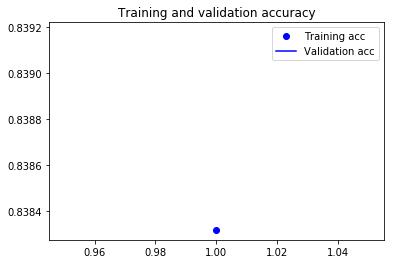

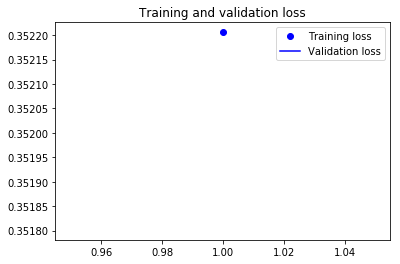

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
# some samples in training set
for i in range(10,15):
    s=data[i]
    x=toIndex(s,dic)
    #print(x)
    pred=model.predict(x)
    #print(toTag(pred,len(s)))
    print(toResult(s,pred))

['去年', '董云', '以539分', '考', '上', '了', '[', '广', '东', '工业', '大学', '，', '“', '学', '业', '还', '是', '妈', '妈', '？', '”', '曾', '让', '董云', '难', '以', '抉择', '，', '最终', '她', '选择', '了', '带着', '妈', '妈', '上', '大学', '，', '举家', '迁', '来', '广州', '，', '边', '读', '书', '，', '边', '照', '顾妈', '妈', '。']
['“', '董云', '，', '热', '水袋', '充好', '了', '吗', '？', '”', '妈', '妈', '在', '房', '间', '擦着', '眼泪', '说', '，', '桌', '上', '的', '电', '热', '水袋', '刚', '充', '了', '[5分', '钟', '电', '，', '董云', '正', '抽', '空', '在', '客', '厅', '啃', '着', '隔夜', '的', '凉', '包子', '。']
['摸', '摸', '热', '水袋', '温度', '差', '不多', '了', '，', '董云', '小心', '翼', '翼', '地', '放', '到', '妈', '妈', '脖子', '下', '，', '此时', '已', '是', '8点', '03分', '，', '她', '背起', '书', '包', '飞', '奔着', '下楼', '了', '。']
['董云', '妈', '妈', '告', '诉', '记者', '，', '每逢', '天', '气', '变化', '，', '她', '就', '会', '难', '受', '，', '“', '手', '一', '直抖', '，', '还', '会', '流', '眼泪', '，', '这时', '我', '要', '用', '热', '水袋', '垫', '着', '脖子', '。']
['”', '妈', '妈', '略', '带愧', '疚', '地', '说', '：', '“', '董云', '每天', '早', '上', '8点', '15分',

In [13]:
def readTestData(file_path):
    data=[]
    labels=[]
    f=open(file_path,'r',encoding='utf-8')
    if not f:
        print('Open File Error!')
        return None
    line=f.readline()
    sentence=[]
    label=[]
    while line:
        if len(line)==4:
            # add character to sentence
            sentence.append(line[0])
            # add label
            if line[2]=='S':
                label.append([1,0,0,0])
            elif line[2]=='B':
                label.append([0,1,0,0])
            elif line[2]=='M':
                label.append([0,0,1,0])
            elif line[2]=='E':
                label.append([0,0,0,1])
            else:
                print('Unrecognized Label!')
        elif len(line)==1:               # end of a sentence
            if len(sentence)>0:
                data.append(sentence)
                labels.append(label)
                sentence=[]
                label=[]
        else:
            print('Anomaly Data Format!')
        line=f.readline()
    f.close()
    print('Read File Complete')
    
    # convert character to index
    test_X=[]
    test_y=[]
    if len(data)!=len(labels):
        print('Data Label Match Fail!')
        return None
        
    for i in range(len(data)):
        if len(data[i])!=len(labels[i]):
            return None
        for j in range(len(data[i])):
            if data[i][j] not in dic.keys():
                test_X.append(0)
            else:
                test_X.append(dic[data[i][j]])
            test_y.append(labels[i][j])
    
    return test_X,test_y,data,labels

In [14]:
def P(y_pred,y):
    # Precision
    # y_pred.shape-->N*4
    if len(y_pred)!=len(y):
        print('Label Predict Match Fail!')
        return None
    tag_pred=np.argmax(y_pred,axis=1)
    tag=np.argmax(y,axis=1)
    res=np.array([0,0,0,0],dtype=np.float64)
    count=0
    for i in range(4):
        for j in range(len(tag_pred)):
            if tag_pred[j]==i:
                count+=1
                if tag[j]==i:
                    res[i]+=1
        if count>0:
            res[i]/=count
            count=0
        else:
            res[i]=1
    return res

In [15]:
def R(y_pred,y):
    # Recall
    # y_pred.shape-->N*4
    if len(y_pred)!=len(y):
        print('Label Predict Match Fail!')
        return None
    tag_pred=np.argmax(y_pred,axis=1)
    tag=np.argmax(y,axis=1)
    res=np.array([0,0,0,0],dtype=np.float64)
    count=0
    for i in range(4):
        for j in range(len(tag_pred)):
            if tag[j]==i:
                count+=1
                if tag_pred[j]==i:
                    res[i]+=1
        if count>0:
            res[i]/=count
            count=0
        else:
            res[i]=1
    return res

In [16]:
def F(P,R,alpha=1):
    # F score
    if len(P)!=len(R):
        print('Length Match Fail!')
        return None
    res=np.array([0,0,0,0],dtype=np.float64)
    for i in range(4):
        if P[i]==0 and R[i]==0:
            res[i]=0
        else:
            res[i]=P[i]*R[i]*(1+alpha**2)/(alpha*alpha*P[i]+R[i])
    return res

In [17]:
file_path='test.data'
test_X,test_y,test_data,test_labels=readTestData(file_path)
test_X=np.array(test_X)
test_y=np.array(test_y)
print(test_X.shape)
print(test_y.shape)

Read File Complete
(2042582,)
(2042582, 4)


In [19]:
precisions=np.array([0,0,0,0],dtype=np.float64)
recalls=np.array([0,0,0,0],dtype=np.float64)
F1s=np.array([0,0,0,0],dtype=np.float64)
num_test=len(test_data)
for i in range(num_test):
    
    x=toIndex(test_data[i],dic)
    s=toCharacter(x,character_list)
    pred=model.predict(x)
    
    #print(s)
    #print(toTag(pred,len(s)))
    
    # some samples in test set
    if i<20:
        print(i)
        print(toResult(s,pred))
        print('-----------------------------------------')
    
    precision=P(pred,test_labels[i])
    recall=R(pred,test_labels[i])
    F1=F(precision,recall)
    precisions+=precision
    recalls+=recall
    F1s+=F1
    
    #print('Precision:',precision)
    #print('Recall:',recall)
    #print('F1 score:',F1)
    #print('-----------------------------------------')

precisions/=num_test
recalls/=num_test
F1s/=num_test
print('Total Precision:',precisions)
print('Total Recall:',recalls)
print('Total F1',F1s)

0
['红', '豆', '，', '绿', '豆', '都', '是', '排毒', '圣品', '，', '并', '且', '有', '高', '纤', '维', '低', '脂肪', '的', '特点', '。']
-----------------------------------------
1
['山', '楂', '健', '脾', '开', '胃', '，', '消', '食', '减', '脂', '。']
-----------------------------------------
2
['红枣', '调', '和', '胃气', '[', '补', '血润', '燥', '。']
-----------------------------------------
3
['此方', '共用', '，', '有', '助', '各种', '单品', '的', '功', '效', '最', '大限度', '的', '发挥', '。']
-----------------------------------------
4
['[龙', '山', '长', '参', '：', '主', '要', '作', '其用', '是', '刺', '激功', '能', '低', '下', '的', '生', '理', '系', '统', '，', '使', '其生', '理', '[生', '化', '反', '应', '趋于', '正常', '，', '并', '阻止', '由', '于', '各种', '原', '因', '引起', '的', '恶性', '循', '环', '，', '以达', '到', '[', '排毒', '养', '颜', '延年', '益', '寿', '的', '目', '的', '。']
-----------------------------------------
5
['红', '豆', '[', '减肥', '食谱']
-----------------------------------------
6
['[', '减肥', '食谱']
-----------------------------------------
7
['材', '料', '：', '红', '豆', '[100克', '，', '